In [3]:
import tensorflow as tf

import numpy as np

In [4]:
from datetime import datetime
import pandas as pd
import requests


def convertTimeStampToUTC(data):
    
    return datetime.fromtimestamp(data)
  
def getURL(apiKey, cryptoSymbol, frequency, timestamp, maxRecords):
    
    API_KEY = '&api_key=' + str(apiKey)
    limit = '&limit=' + str(maxRecords)
    header = 'fsym=' + str(cryptoSymbol)
    currency = '&tsym=USD'

    if (timestamp == ""):
        url = 'https://min-api.cryptocompare.com/data/v2/histo' + frequency + '?' + header
    
    else:  
        url = 'https://min-api.cryptocompare.com/data/v2/histo' + frequency + '?' + header + '&toTs=' + str(timestamp)

    return url + currency + API_KEY + limit  


def getCryptoData(apiKey, crypto, frequency, numOfRequests, maxRecords):
    
    numOfRequests = 5
    data = pd.DataFrame()
    nextTimeStamp = 0

    for i in range(0, numOfRequests):
        if (nextTimeStamp == 0):
            url = getURL(apiKey, crypto, frequency, "", maxRecords)
    
        else:
            url = getURL(apiKey, crypto, frequency, nextTimeStamp, maxRecords)

        response = requests.get(url).json()
        partialData = pd.DataFrame(response.get('Data').get('Data'))
        nextTimeStamp = partialData['time'].min() - 1
        data = pd.concat([data, partialData])

    data = data.sort_values(by = ['time'],ignore_index = True)
    data['timeUTC'] = data['time'].apply(convertTimeStampToUTC)
    data = data.reset_index(drop = True)
    return data

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('bitcoin2000.csv')

In [20]:
data.set_index(['timeUTC'],inplace=True)
#data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

In [21]:
from sklearn.preprocessing import MinMaxScaler
values = data['close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
ts = scaler.fit_transform(values)

In [22]:
timestep = 6

X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 8000
Xtrain = X[:k,:,:]  
Ytrain = Y[:k]   

In [28]:
Xtrain.shape

(8000, 6, 1)

In [23]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(6, 1)))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, Ytrain, epochs=200, verbose=1)

Epoch 1/200
250/250 [==============================] - 0s 1ms/step - loss: 3.1353e-04
Epoch 2/200
250/250 [==============================] - 0s 1ms/step - loss: 9.9995e-06
Epoch 3/200
250/250 [==============================] - 0s 1ms/step - loss: 9.5497e-06
Epoch 4/200
250/250 [==============================] - 0s 1ms/step - loss: 1.0132e-05
Epoch 5/200
250/250 [==============================] - 0s 1ms/step - loss: 1.0898e-05
Epoch 6/200
250/250 [==============================] - 0s 1ms/step - loss: 8.6974e-06
Epoch 7/200
250/250 [==============================] - 0s 1ms/step - loss: 8.2926e-06
Epoch 8/200
250/250 [==============================] - 0s 1ms/step - loss: 8.6907e-06
Epoch 9/200
250/250 [==============================] - 0s 1ms/step - loss: 8.0593e-06
Epoch 10/200
250/250 [==============================] - 0s 1ms/step - loss: 1.0145e-05
Epoch 11/200
250/250 [==============================] - 0s 1ms/step - loss: 9.0980e-06
Epoch 12/200
250/250 [==============================

250/250 [==============================] - 0s 1ms/step - loss: 4.7919e-06
Epoch 189/200
250/250 [==============================] - 0s 1ms/step - loss: 4.5069e-06
Epoch 190/200
250/250 [==============================] - 0s 1ms/step - loss: 4.1472e-06
Epoch 191/200
250/250 [==============================] - 0s 1ms/step - loss: 4.2796e-06
Epoch 192/200
250/250 [==============================] - 0s 1ms/step - loss: 4.2226e-06
Epoch 193/200
250/250 [==============================] - 0s 1ms/step - loss: 4.2961e-06
Epoch 194/200
250/250 [==============================] - 0s 1ms/step - loss: 4.3644e-06
Epoch 195/200
250/250 [==============================] - 0s 1ms/step - loss: 4.0141e-06
Epoch 196/200
250/250 [==============================] - 0s 1ms/step - loss: 4.1932e-06
Epoch 197/200
250/250 [==============================] - 0s 1ms/step - loss: 4.3924e-06
Epoch 198/200
250/250 [==============================] - 0s 1ms/step - loss: 4.4147e-06
Epoch 199/200
250/250 [=======================

In [24]:
Xtest = X[k:,:,:]  
Ytest= Y[k:]  

In [25]:
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)


155710.14

In [26]:
from math import *

sqrt(mean_squared_error(Ytest,preds))

394.60124255379634

In [127]:
sqrt(mean_squared_error(Ytest,preds))

552.5672187616634

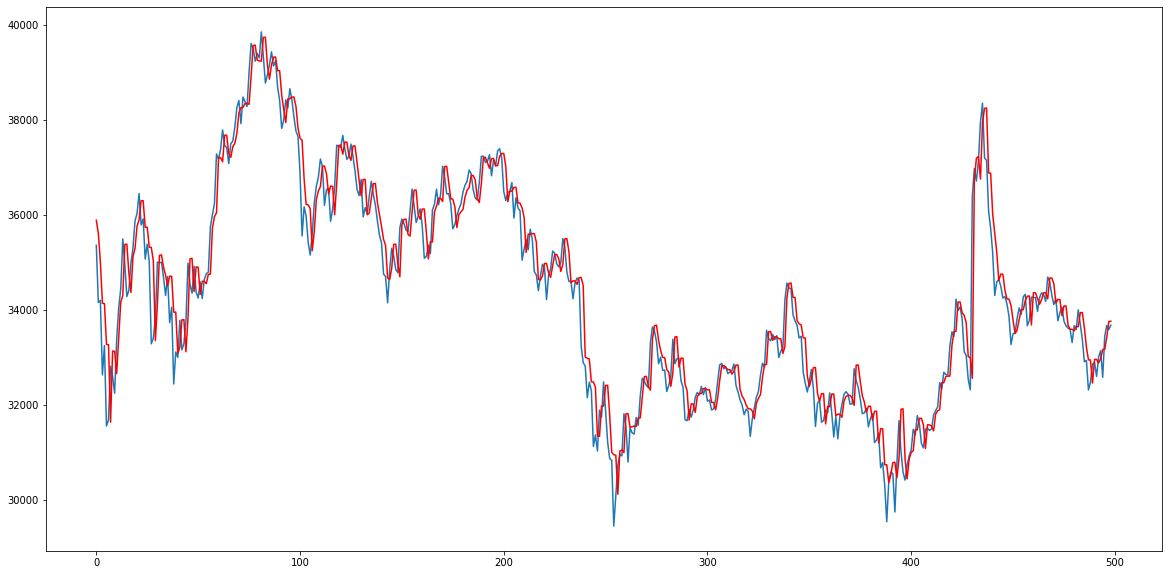

In [128]:
from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
pyplot.plot(Ytest)
pyplot.plot(preds, 'r')
pyplot.show()

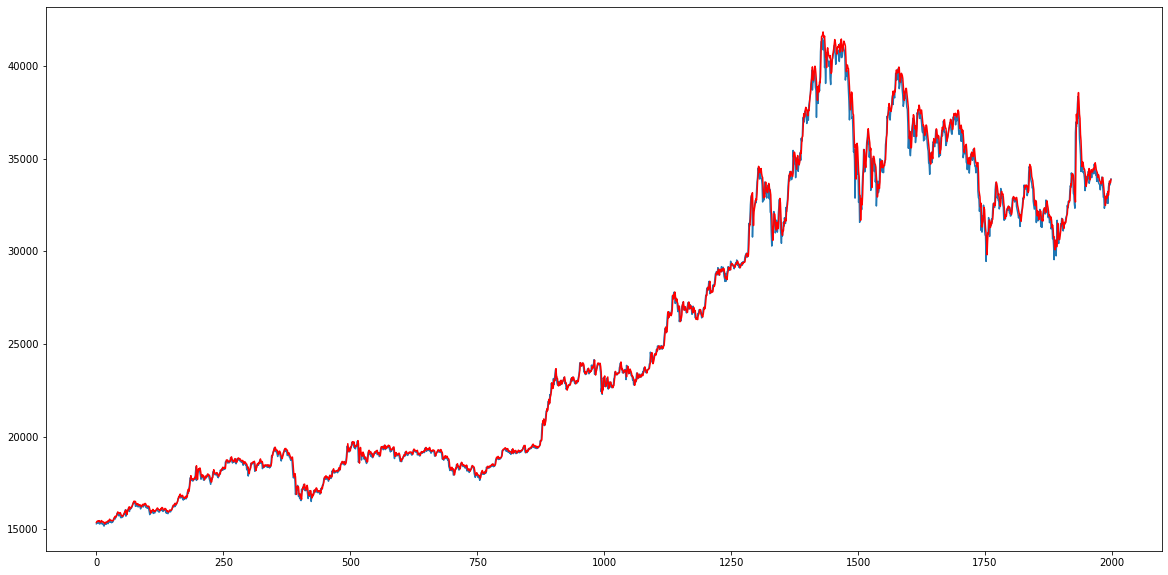

In [27]:
from matplotlib import pyplot
pyplot.figure(figsize=(20,10))
pyplot.plot(Ytest)
pyplot.plot(preds, 'r')
pyplot.show()